
## Problem Set 3 [25 points]
### Neural Networks

<div class="alert alert-info">
In this problem set, you are to implement a two-layer (2 layers of weights, 1 hidden layer of units) neural network for binary classification.  All non-linearities are to be sigmoids.

Details are given below.  *Please read the **entire** notebook carefully before proceeding.*

You need to both fill in the necesary code, **and** answer the question at the bottom.</div>

In [1]:
# Below are the only imports that are necessary (or allowed)
import numpy as np
import h5py 
import matplotlib.pyplot as plt
import time
from IPython import display

## Data

<div class="alert alert-info">
We will be using a USPS digit dataset (provided in the file uspsall73.mat).
It has 16-by-16 grayscale images of each of the 10 different hand-written digits
However, we will load only two of the digits to use as the two classes in
binary classification
</div>

In [2]:
start = time.time()

# function to load two of the 10 classes (c1 is for Y=+1 and c2 is for Y=0)
# Note that for neural networks, we will be using Y={+1,0} instead of Y={+1,-1}
def loaddigitdata(c1,c2,m):
    f = h5py.File('uspsall73.mat','r') 
    data = f.get('data') 
    data = np.array(data).astype(float)
    X = np.concatenate((data[c1,:,:],data[c2,:,:]))
    Y = np.concatenate((np.zeros((data.shape[1])),np.ones((data.shape[1]))))
    
    rndstate = np.random.get_state() # going to set the "random" shuffle random seed
    np.random.seed(132857) # setting seed so that dataset is consistent
    p = np.random.permutation(X.shape[0])
    X = X[p] # this and next line make copies, but that's okay given how small our dataset is
    Y = Y[p]
    np.random.set_state(rndstate) # reset seed
    
    trainX = X[0:m,:] # use the first m (after shuffling) for training
    trainY = Y[0:m,np.newaxis]
    validX = X[m:,:] # use the rest for validation
    validY = Y[m:,np.newaxis]
    return (trainX,trainY,validX,validY)

# In case you care (not necessary for the assignment)
def drawexample(x,ax=None): # takes an x *vector* and draws the image it encodes
    if ax is None:
        plt.imshow(np.reshape(x,(16,16)).T,cmap='gray')
    else:
        ax.imshow(np.reshape(x,(16,16)).T,cmap='gray')

In [3]:
# load the data, to differentiate between 7s and 9s
# we will use on 550 examples for training (10% of the data)
# to speed up computational time (usually we would use a lot more)
(trainX,trainY,validX,validY) = loaddigitdata(6,8,550)

## WRITE `nneval` and `trainneuralnet` [20 points]

<div class="alert alert-info">
This is the main portion of the assignment

Note that the $Y$ values are +1 and 0 (not +1 and -1).  This is as in class and works better with a sigmoid output.

You need to write the two functions below (plus any more you would like to add to help): `nneval` and `trainneuralnet`.  The first takes an array/matrix of X vectors and the weights from a neural network and returns a vector of predicted Y values (should be numbers between 0 and 1 -- the probability of class +1, for each of the examples).  The second takes a data set (Xs and Ys), the number of hidden units, and the lambda value (for regularization), and returns the weights.  W1 are the weights from the input to the hidden and W2 are the weights from the hidden to the output.

A few notes:
- **Starting Weights**: Start the weights randomly using `np.random.randn` (each weight is drawn from a normal distribution with mean 0 and standard deviation of 1).  Then divide all weights by the number of elements in the previous layer.  This is already included in the code below.
- **Offset Terms**: Each layer should have an "offset" unit (to supply a 1 to the next layer), except the output layer.
- **Batch Updates**: For a problem this small, use batch updates.  That is, the step is based on the sum of the gradients for each data point in the training set.
- **Step Size**: http://ruder.io/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms describes a number of methods to adaptively control $\eta$ for fast convergence.  You don't need to understand any of them; however, without them, convergence to good solutions on this problem can be quite slow.  Therefore, *use RMSprop*: the code below has a simple version of RMSprop that is sufficient for this assignment.  You need to supply the code that calculates `sumofgrad2` which should be the sum of the square of each element of the gradient (the squared length of the gradient).  (for debugging, feel free to use a constant $\eta$). 
- **Stopping Criterion**: To determine when to stop, check the loss function every 1000 iterations.  If it has not improved by at least $10^{-6}$ over those 1000 iterations, stop.
- **Regularization**: You should penalize (from the regularization) all of the weights, even those coming out of offset units.  While it makes sense sometimes not to penalize the ones for the constant $1$ units, you'll find this easier if you just penalize them all.

Tips that might help:
- Display the loss function's value every 1000 iterations (or so).  It should generally be getting smaller.
- The smaller $\lambda$ is and the more units, the more difficult the optimization will be.
- Write a function to do forward propagation and one to do backward propagation.  Write a function to evaluate the loss function.  In general, break things up to keep things straight.
- Processing the entire batch at once is more efficient in numpy.  Use numpy broadcasting to avoid loops where possible.
</div>

In [4]:
### FEEL FREE TO ADD HELPER FUNCTIONS

### SOME LITTLE BASIC FUNCTIONS
# add offset units
def offset(X):
    (m,n) = X.shape
    temp = np.ones((m,1))
    X = np.c_[temp,X]
    return X

### I wrote these functions at the beginning
### but call functions will waste lots of time, so I didn't use them in nneval and trainneuralnet
### I only leave them here to show a more clear thought
'''# sigmoid function
def sigmoid(Z):
    A = 1.0/(1+np.exp(-Z))
    return A

# forward propagation
def forward(W,A):
    Z = A@W.T
    A = sigmoid(Z)
    return Z,A

# backward propagation
def backward(A,W,D):
    return (D*A*(1-A)).T*W.T

# gradient
def gradient(D,A):
    return D.T@A

# loss function (with regularization)
def lossfunc(m,Y,F,lam,W1,W2):
    l = -Y*np.log10(F)-(1-Y)*np.log10(1-F)
    L = (1/m)*sum(sum(l))+(lam/m)*(sum(sum(W1*W1))+sum(sum(W2*W2)))
    return L'''

def nneval(X,W1,W2): 
    ### YOUR CODE HERE
    oX = offset(X)
    (m,n) = oX.shape
    Y = np.zeros((m,1))
    Z1 = oX@W1.T
    A1 = 1.0/(1+np.exp(-Z1)) # .shape =  (m,nhid)
    A1 = offset(A1)
    Z2 = A1@W2.T
    Y = 1.0/(1+np.exp(-Z2)) # .shape = (m,1)
    return Y

def trainneuralnet(X,Y,nhid,lam):
    (m,n) = X.shape
    
    W1 = np.random.randn(nhid,n+1)/n # weights to each hidden unit from the inputs (plus the added offset unit)
    W2 = np.random.randn(1,nhid+1)/nhid # weights to the single output unit from the hidden units (plus the offset unit)
    #W1 = np.array([[0.,0.,1.,2.],[-2.,1.,-1.,1.]])
    #W2 = np.array([[4.,-5.,2.]])
    
    Eg2=1 ## just to initialize for the RMSprop rule for eta, below.
    
    ### YOUR CODE HERE (the code below is just to help)
    oX = offset(X)
    (m,n) = oX.shape
    k = 0
    l = 999999
    
    while 1:
        F = np.zeros((m,1))
        Z1 = oX@W1.T
        A1 = 1.0/(1+np.exp(-Z1))
        A1 = offset(A1)
        Z2 = A1@W2.T
        F = 1.0/(1+np.exp(-Z2))
        D2 = F-Y
        D1 = (D2*A1*(1-A1)).T*W2.T
        G2 = D2.T@A1
        D1 = np.delete(D1,0,0)
        G1 = D1@oX
        
        G1 = G1/m
        G2 = G2/m
        
        ## Loop to convergence
        # below is a nice formula to set eta.  You can use eta=0.1 or eta=0.01 for debugging,
        # but use this formula to get much faster convergence for the final solution!
        sumofgrad2 = sum(sum(G1*G1))+sum(sum(G2*G2))
        Eg2 = 0.9*Eg2 + 0.1*sumofgrad2
        eta = 0.001/np.sqrt(1e-10+Eg2)
        
        W1 -= (G1+2*lam/m*W1)*eta
        W2 -= (G2+2*lam/m*W2)*eta
        
        k += 1
        ## every 1000 iterations, check the loss function (including regularization!)
        ## if it has not decreased by at least 1e-6 over the past 1000 iterations, *break the loop*
        if k == 1000:
            L = -Y*np.log10(F)-(1-Y)*np.log10(1-F)
            temp = (1/m)*sum(sum(L))+(lam/m)*(sum(sum(W1*W1))+sum(sum(W2*W2)))
            if l-temp < 1e-6 and 0 <= l-temp: break
            l = temp
            k = 0
    
    return (W1,W2)

In [5]:
# Use this cell (or others you add) to check your network
# I would debug on simple examples you create yourself (trying to understand what happens with
#  the full 256-dimensional data is hard)
   
time1 = time.time()
(W1,W2) = trainneuralnet(trainX,trainY,5,0.1) #an example of training on the USPS data with 5 hidden units and lambda=0.1
print(W1)
print(W2)
print("Running time for this example is: ",time.time()-time1," seconds.")

[[ 1.81730103e-04  3.65221213e-03 -1.46231386e-03 ...  3.80110650e-03
   3.14616600e-03  6.13308624e-04]
 [ 7.78422975e-04  4.11701305e-03 -7.93444335e-04 ...  3.33217689e-03
   3.28642454e-03  5.69113297e-04]
 [ 4.38998750e-04  4.78373165e-03 -1.36074503e-03 ...  3.75162468e-03
   2.97645740e-03  6.72776138e-04]
 [ 5.77416206e-05 -3.83483649e-03 -1.32332176e-03 ... -3.11455906e-03
  -3.06169167e-03 -1.17177297e-03]
 [ 8.71007313e-06  3.53274248e-03 -1.32513863e-03 ...  3.39237417e-03
   3.11988512e-03  9.63871220e-04]]
[[ 1.96289333 -2.14154363 -2.08532613 -2.17264455  3.83804169 -2.17715714]]
Running time for this example is:  13.76636528968811  seconds.


## Performance plot
<div class="alert alert-info">
The code below will plot your algorithm's error rate on this data set for various regularization strengths and numbers of hidden units.

Make sure your code works for this plot.

My code runs in about 7 minutes (to produce the full plot below)
</div>

Running time for this whole notebook is 11 minute(s) and 7 second(s).


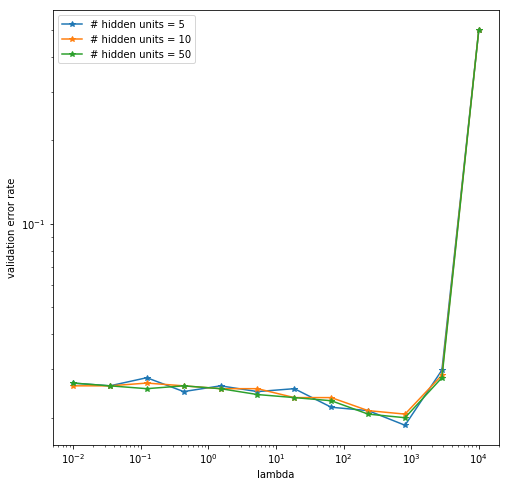

In [6]:
def setupfig():
    f = plt.figure()
    f.set_size_inches(8,8)
    ax = f.add_subplot(111)
    plt.ion()
    f.canvas.draw()
    return (f,ax)

def plotit(lams,nhiddens,erates,f,ax):
    ax.clear()
    for i in range(nhiddens.shape[0]):
        ax.loglog(lams,erates[:,i],'*-')
    f.canvas.draw()
    ax.set_xlabel('lambda')
    ax.set_ylabel('validation error rate')
    ax.legend(['# hidden units = '+str(x) for x in nhiddens])
    display.display(f)
    display.clear_output(wait=True)
    
    
nhiddens = np.array([5,10,50])
lams = np.logspace(-2,4,12)
erates = np.empty([lams.shape[0],nhiddens.shape[0]])
erates[:,:] = np.nan

(f,ax) = setupfig()
for li, lam in reversed(list(enumerate(lams))):
    for ni, nhid in enumerate(nhiddens):
        (W1,W2) = trainneuralnet(trainX,trainY,nhid,lam)
        predy = nneval(validX,W1,W2)
        predy[predy<0.5] = 0
        predy[predy>=0.5] = 1
        validerr = (predy != validY).sum()/validY.shape[0]
        erates[li,ni] = validerr
        
        plotit(lams,nhiddens,erates,f,ax)
        
end = time.time()
print("Running time for this whole notebook is ",end = "")
print(int((end-start)//60),end = "")
print(" minute(s) and ",end = "")
print(int((end-start)%60),end = "")
print(" second(s).")


## INTERPRET the Plot (part b) [5 points]
<div class="alert alert-info">
How do you interpret the plot above?  How and why does the plot differ by number of hidden units?  By $\lambda$ value?
</div>

### Your Answer Here

- For hidden units:
    1. The differences between numbers of hidden units aren't too obvious.
        The difference is small, especially when number of hidden units gets higher (as 10 and 20). With **the number of hidden** units getting higher, **the complexity and the ability of learning** for the hidden layer also goes up, which would make the accuracy get better. But once the hidden units are enough, it won't make a big difference when it gets even higher, since the hidden layer **is already able** to learn about whatever it need to learn.
        So, the differences for 5, 10, and 20 hidden units aren't too much, especially for 10 and 20, they basically share the same error rate.
    2. Generally, the higher the number of hidden units is, the lower the error rate gets; but it's not certain.
        From the plot, generally higher number of units can give a better result. Since higher units have higher complexity, it should be better at learning. But there are also some examples shows lower number hidden units have better results. **The reason is regularization.** Since higher number of hidden units generates more elements for weights, the penalty from regularization also gets higher, it can affect the accuracy for the neural network. Another reason is the starting weights **are randomly chosen**, the performance for the neural network can be affected by it. (To be honest, when I do this homework, I run the plotting for multiple times. The basic trend of error rate is the same, but the exact relationship of error rates between different numbers of hidden units could change.)
        
- For $\lambda$ value
    1. The neural network have the lowest error rate when $\lambda=10^4/(\sqrt[11]{10^6})^2$.
        It's **shown in the plot** itself. $\lambda$ represents the strength of regularization, and there isn't a specific explaination for why the neural network performs the best when $\lambda$ is equal to that value.
    2. The error rate goes up for both directions from the minimum.
        When $\lambda$ **gets higher or lower** from $10^4/(\sqrt[11]{10^6})^2$, the error rate all **goes up**. When $\lambda$ is too low, the neural network can be overfit; and when it's too high, the neural network can be too general. It should goes up when leave the minimum, as in the plot. And when $\lambda=10^4$, it's so high that make the error rate goes higher than 0.5.